In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from scipy.stats import skew
from sklearn.cluster import KMeans

from utils import show_images, load_image, preprocess_image
from segmentation import segment_leaf_hsv, clean_mask, segment_lesion_lab_kmeans, clean_lesion_mask, segment_lesion_lab_threshold
from feature_extractor import compute_color_moments, compute_glcm_features, compute_lbp_features, compute_shape_features, extract_feature_vector

from config import DATASET_PATH
import utils

In [2]:
def process_image_pipeline(image_path, debug_visual=False):
    """
    Chạy toàn bộ pipeline cho 1 ảnh:
    - load & preprocess
    - segment leaf
    - segment lesion
    - clean masks
    - extract feature vector

    Trả về:
    - feature_vector (numpy array)
    - dict intermediate (chứa các ảnh/mask trung gian nếu cần dùng)
    """
    # 1. Load & preprocess
    img_bgr_raw, img_rgb_raw = load_image(image_path)
    img_bgr, img_rgb = preprocess_image(img_bgr_raw, target_size=(256, 256))

    # 2. Segment leaf (HSV) + clean
    mask_leaf = segment_leaf_hsv(img_bgr, lower_green=[15, 25, 10])
    mask_leaf_clean = clean_mask(mask_leaf, ksize=7)

    # 3. Segment lesion (Lab + K-means) + clean
    mask_lesion_raw, labels_full = segment_lesion_lab_kmeans(img_rgb, mask_leaf_clean, k=3)
    mask_lesion_clean = clean_lesion_mask(mask_lesion_raw, min_area=50, ksize=5)

    # 4. Extract features
    feature_vector = extract_feature_vector(img_rgb, mask_leaf_clean, mask_lesion_clean)

    # 5. Lưu các bước trung gian (để vẽ / debug / ghi vào báo cáo)
    intermediates = {
        "img_rgb_raw": img_rgb_raw,
        "img_rgb": img_rgb,
        "mask_leaf": mask_leaf_clean,
        "mask_lesion": mask_lesion_clean,
    }

    if debug_visual:
        # Tô overlay vùng bệnh lên ảnh
        overlay = img_rgb.copy()
        red_layer = np.zeros_like(img_rgb)
        red_layer[:, :, 0] = 255
        alpha = 0.5
        mask_bool = mask_lesion_clean.astype(bool)
        overlay[mask_bool] = (
            alpha * overlay[mask_bool] + (1 - alpha) * red_layer[mask_bool]
        ).astype(np.uint8)

        show_images(
            [img_rgb, mask_leaf_clean, mask_lesion_clean, overlay],
            ["Ảnh sau preprocess", "Mask lá", "Mask vùng bệnh", "Overlay vùng bệnh"],
            cols=4,
            figsize=(14, 4)
        )

    return feature_vector, intermediates

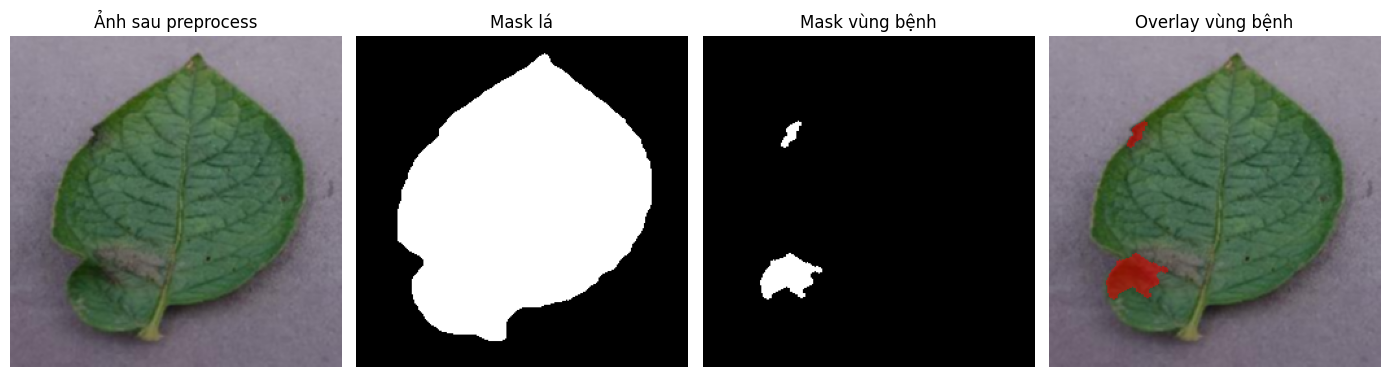

Kích thước vector đặc trưng: (29,)
Một phần vector đặc trưng: [69.40514    15.49955     0.2714009  99.16706    15.333055   -0.86317515
 68.146065   16.969744   -0.6487608   0.33961397]


In [3]:
images_folder_path = DATASET_PATH / "Potato___Late_blight"
image_path = utils.get_random_file(images_folder_path)
fv, inter = process_image_pipeline(image_path, debug_visual=True)
print("Kích thước vector đặc trưng:", fv.shape)
print("Một phần vector đặc trưng:", fv[:10])

In [4]:
def process_image_pipeline_threshold(image_path, debug_visual=False):
    img_bgr_raw, img_rgb_raw = load_image(image_path)
    img_bgr, img_rgb = preprocess_image(img_bgr_raw, target_size=(256, 256))

    # Segment leaf
    mask_leaf = segment_leaf_hsv(img_bgr)
    mask_leaf_clean = clean_mask(mask_leaf, ksize=7)

    # Segment lesion bằng Lab + threshold
    mask_lesion_raw, used_thresh = segment_lesion_lab_threshold(
        img_rgb,
        mask_leaf_clean,
        channel="a",    # hoặc thử "b" xem kênh nào tốt hơn
        thresh=None,    # None = Otsu
        mode="greater"  # hoặc "less"
    )
    mask_lesion_clean = clean_lesion_mask(mask_lesion_raw, min_area=50, ksize=5)

    # Extract features như cũ
    feature_vector = extract_feature_vector(img_rgb, mask_leaf_clean, mask_lesion_clean)

    if debug_visual:
        overlay = img_rgb.copy()
        red_layer = np.zeros_like(img_rgb)
        red_layer[:, :, 0] = 255
        alpha = 0.5
        mask_bool = mask_lesion_clean.astype(bool)
        overlay[mask_bool] = (
            alpha * overlay[mask_bool] + (1 - alpha) * red_layer[mask_bool]
        ).astype(np.uint8)

        show_images(
            [img_rgb, mask_leaf_clean, mask_lesion_clean, overlay],
            [
                "Ảnh sau preprocess",
                "Mask lá",
                f"Mask bệnh (Lab threshold, a*, T={used_thresh:.1f})",
                "Overlay vùng bệnh"
            ],
            cols=4,
            figsize=(14, 4)
        )

    return feature_vector


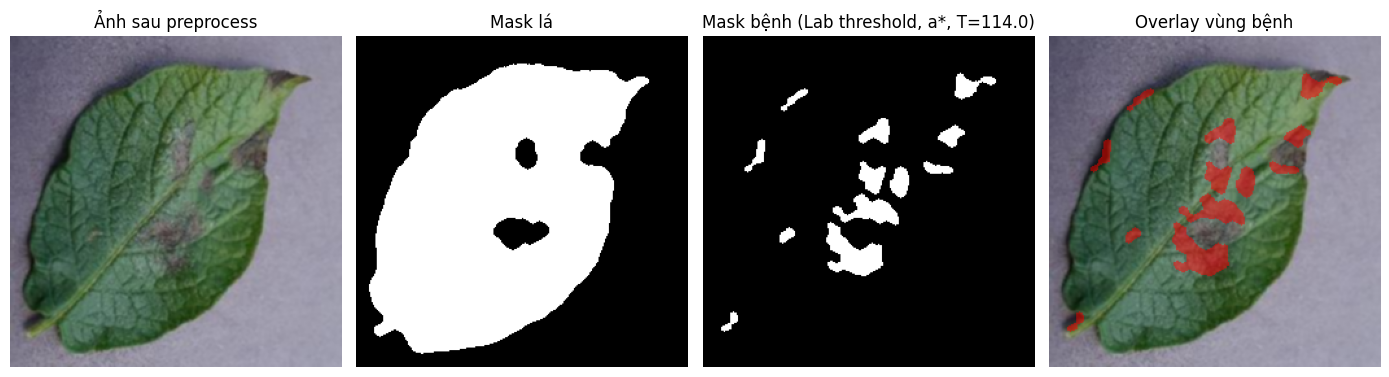

Kích thước vector đặc trưng: (29,)
Một phần vector đặc trưng: [ 7.42821503e+01  2.33615780e+01  9.91830900e-02  1.03716675e+02
  2.29513664e+01 -1.97749659e-01  7.38986511e+01  2.30025158e+01
 -2.11584970e-01  4.32689965e-01]


In [6]:
images_folder_path = DATASET_PATH / "Potato___Late_blight"
image_path = utils.get_random_file(images_folder_path)
fv = process_image_pipeline_threshold(image_path, debug_visual=True)
print("Kích thước vector đặc trưng:", fv.shape)
print("Một phần vector đặc trưng:", fv[:10])